# Оценка результатов A/B теста

**Цель проекта:** Оценить корректность проведения теста и проанализировать полученные резльутаты.

**Задачи проекта:**

* Дать оценку корректности A/B теста
* Провести исследовательский анализ данных
* Оценить результаты теста по ключевым событиям
* Проверить статистические гипотезы
* Сформулировать выводы и дать рекомендации

**Содержание**
* 1. Описание данных
* 2. Предобработка данных
    * 2.1  Преобразование типов данных
    * 2.2  Анализ пропусков
    * 2.3  Анализ дубликатов
* 3. Оценка корректности A/B теста
    * 3.1  Проверка времени проведения теста
    * 3.2  Проверка аудитории теста
* 4. Исследовательский анализ данных
    * 4.1  Распределение количества событий на пользователя по группам
    * 4.2  Распределение числа событий в выборках по дням
    * 4.3  Изменение конверсии в воронке в выборках на разных этапах
* 5. Оценка результатов A/B-тестирования
    * 5.1  Создание расчётных функций для анализа
    * 5.2  Анализ конверсии просмотра товара
    * 5.3  Анализ конверсии просмотра корзины
    * 5.4  Анализ конверсии покупок
    * 5.5  Анализ выручки
    * 5.6  Проверка статистической разницы долей z-критерием
* 6. Общие выводы и рекомендации

## Описание данных

Импортируем все необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import math as mth
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats as st

Загрузим датасет с календарём маркетинговых событий на 2020 год.

In [2]:
data_marketing_events = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/9. Оценка результатов AB теста/data_marketing_events.csv')
data_marketing_events.info()
data_marketing_events.sample (5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Датасет содержит 14 записей. Пропусков в данных не наблюдается. Тип данных в колонках `start_dt` и `finish_dt` необходимо преобразовать в `datetime`.

**Описание датасета:**

* `name` — название маркетингового события
* `regions` — регионы, в которых будет проводиться рекламная кампания
* `start_dt` — дата начала кампании
* `finish_dt` — дата завершения кампании

Загрузим датасет с информацией о пользователях, зарегистрировавшихся в интернет-магазине в период с 7 по 21 декабря 2020 года.

In [3]:
data_new_users = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/9. Оценка результатов AB теста/data_new_users.csv')
data_new_users.info()
data_new_users.sample (5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
22837,C16C91FA9D96120F,2020-12-15,EU,PC
11002,D0C40E3995310147,2020-12-14,EU,PC
45323,07A1A37AA36EA645,2020-12-12,EU,PC
24151,6A6F7D12E5E6A39D,2020-12-22,N.America,iPhone
34698,5B689255E8BA7410,2020-12-10,EU,Mac


Датасет содержит 61733 записей. Пропусков в данных не наблюдается. Тип данных в колонкe `first_date` необходимо преобразовать в `datetime`.

**Описание датасета:**
* `user_id` — идентификатор пользователя
* `first_date` — дата регистрации
* `region` — регион пользователя
* `device` — устройство, с которого происходила регистрация

Загрузим датасет с информацией о событиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

In [4]:
data_ab_events = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/9. Оценка результатов AB теста/data_events.csv')
data_ab_events.info()
data_ab_events.sample (5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
155871,8C415E32B00363D1,2020-12-14 11:53:34,product_page,NaN
387397,DF0EA365CCAEAA80,2020-12-22 15:17:54,login,NaN
338246,77271E21336D1FF8,2020-12-18 23:45:50,login,NaN
397867,1CC55BFAC88A350E,2020-12-23 08:22:08,login,NaN
243855,E676E162E31124E9,2020-12-27 07:17:43,product_page,NaN


Датасет содержит 440317 записей. Имеется большое количество пропусков в колонке `details`. Тип данных в колонке `event_dt` необходимо преобразовать в `datetime`.

**Описание датасета:**
* `user_id` — идентификатор пользователя
* `event_dt` — дата и время события
* `event_name` — тип события
* `details` — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах

Загрузим датасет с информацией об участниках A/B тестов.

In [5]:
data_ab_users = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/9. Оценка результатов AB теста/data_participants.csv')
data_ab_users.info()
data_ab_users.sample (5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
2039,9270DB42112E3B14,A,recommender_system_test
8776,D9715C63505DA68F,A,interface_eu_test
9163,DDA59D11FFAA7F27,A,interface_eu_test
12034,A96FEDF7E03DC8B3,B,interface_eu_test
5771,F3B869BA0D5F6FE2,A,recommender_system_test


Датасет содержит 18268 записей. Пропусков в данных не наблюдается. Типы данных указаны корректно.

**Описание датасета:**
* `user_id` — идентификатор пользователя
* `ab_test` — название теста
* `group` — группа пользователя

## Предобработка данных
### Преобразование типов данных

Для начала преобразуем типы данных в `datetime` во всех колонках датасетов, где это требуется.

In [6]:
data_marketing_events ['start_dt'] = pd.to_datetime (data_marketing_events ['start_dt'], format = '%Y.%m.%d')
data_marketing_events ['finish_dt'] = pd.to_datetime (data_marketing_events ['finish_dt'], format = '%Y.%m.%d')
data_new_users ['first_date'] = pd.to_datetime (data_new_users ['first_date'], format = '%Y.%m.%d')
data_ab_events ['event_dt'] = pd.to_datetime (data_ab_events ['event_dt'], format = '%Y.%m.%d %H:%M:%S')

### Анализ пропусков
Посмотрим на пропуски в значениях колокни `details` в датасете `data_ab_events`.

In [7]:
data_ab_events.groupby ('event_name')['details'].nunique()

event_name
login           0
product_cart    0
product_page    0
purchase        4
Name: details, dtype: int64

In [8]:
data_ab_events.query ('event_name == "purchase"').isna().sum()

user_id       0
event_dt      0
event_name    0
details       0
dtype: int64

Пропуски встречаются в данных, где тип события - не покупка. При наличии покупки пропуски в колонке `details` отсутствуют. В данном случае наиболее правильным решением будет оставить пропуски незаполненными.

### Анализ дубликатов
Посмотрим на наличие явных дубликатов в данных.

In [9]:
for i in [data_marketing_events, data_new_users, data_ab_events, data_ab_users]:
    display (i.duplicated().sum())

0

0

0

0

Явные дубликаты в данных отсутстуют. Проверим коррекность значений некоторых категориальных переменных для выявления неявных дубликатов.

In [10]:
for i in [data_new_users ['region'],
          data_new_users ['device'],
          data_ab_events ['event_name'],
          data_ab_users ['group'],
          data_ab_users ['ab_test']]:
    print (i.unique())

['EU' 'N.America' 'APAC' 'CIS']
['PC' 'Android' 'iPhone' 'Mac']
['purchase' 'product_cart' 'product_page' 'login']
['A' 'B']
['recommender_system_test' 'interface_eu_test']


Дубликаты в данных отсутствуют.

## Оценка корректности A/B теста
### Проверка времени проведения теста

Проверим время проведения теста. Согласно техническому заданию:

* Дата запуска: 2020-12-07
* Дата остановки набора новых пользователей: 2020-12-21
* Дата остановки: 2021-01-04

In [11]:
print (data_new_users ['first_date'].min())
print (data_new_users ['first_date'].max())

2020-12-07 00:00:00
2020-12-23 00:00:00


Дата окончания набора новых пользователей не совпадает с датой из ТЗ. Проверим количество пользователей, зарегистрировавшихся позже 21 декабря.

In [12]:
users_merge = data_ab_users.query ('ab_test == "recommender_system_test"').merge (data_new_users, on = 'user_id')
print (users_merge ['first_date'].min())
print (users_merge ['first_date'].max())

2020-12-07 00:00:00
2020-12-21 00:00:00


In [13]:
data_new_users.query ('first_date > "2020-12-21"')['user_id'].count()

5263

5263 пользователей зарегистрировались позже 21 декабря 2020 года, это более 8.5% от общего объёма данных в датасете с новыми пользователями. Оставим для анализа только тех, кто зарегистрировался до 21.12.2020 включительно.

In [14]:
data_new_users = data_new_users.query ('first_date <= "2020-12-21" & region == "EU"')

Проверим соответствие даты начала и остановки проведения теста.

In [15]:
print (data_ab_events ['event_dt'].min())
print (data_ab_events ['event_dt'].max())

2020-12-07 00:00:33
2020-12-30 23:36:33


Дата остановки теста на 5 дней больше, чем дата последней записи в датасете о событиях пользователей. Это может быть связано как с ошибкой при сохранении данных, так и с новогодними праздниками в период с 31 декабря по 4 января.

Проверим, совпадает ли время проведения теста с маркетинговыми активностями.

In [16]:
data_marketing_events.query ('finish_dt >= "2020-12-07"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


В период проведения A\B теста проводились две маркетинговые кампании, одна из которых (`Christmas&New Year Promo`) проходила среди пользователей из региона `EU`, имеющими отношение к нашему A\B тесту.

### Проверка аудитории теста
Проверим наличие пересечений между двумя группами A/B теста.

In [17]:
data_ab_users_a = data_ab_users.query ('ab_test == "recommender_system_test" & group == "A"')
data_ab_users_b = data_ab_users.query ('ab_test == "recommender_system_test" & group == "B"')
cross_users_ab = data_ab_users_a [data_ab_users_a ['user_id'].isin (data_ab_users_b ['user_id'])]
cross_users_ab_ratio = round ((len (cross_users_ab) / (len (data_ab_users_a) + len (data_ab_users_b)) * 100), 2)
print (f'Доля пользователей, пересекающихся между группами A\B теста: {cross_users_ab_ratio} %')

Доля пользователей, пересекающихся между группами A\B теста: 0.0 %


Проверим наличие пересечений с конкурирующим тестом.

In [18]:
data_ab_users_interface = data_ab_users.query ('ab_test == "interface_eu_test"')
data_ab_users_recommender = data_ab_users.query ('ab_test == "recommender_system_test"')
cross_users_test = data_ab_users_recommender [data_ab_users_recommender ['user_id'].isin (data_ab_users_interface ['user_id'])]
cross_users_test_ratio = round ((len (cross_users_test) / len (data_ab_users_recommender) * 100), 2)
print (f'Доля пользователей, пересекающихся с конкурирующим тестом: {cross_users_test_ratio} %') 

Доля пользователей, пересекающихся с конкурирующим тестом: 23.91 %


Более 23% пользователей пересекаются между группами - это большая доля. Для принятия решения об удалении этих пользователей из анализа, проверим соответствие ожидаемого количества участников теста, а также соответствие доли участников из региона `EU`, описанных в ТЗ, с фактическими данными.

Проверим соответствие пользователей в каждой из групп конкурирующего теста. 

In [19]:
data_ab_users_interface_a = data_ab_users_interface.query ('group == "A"')
data_ab_users_interface_b = data_ab_users_interface.query ('group == "B"')

for i, j in zip ([data_ab_users_interface_a, data_ab_users_interface_b], ['A', 'B']):
    cross_users_test = i [i ['user_id'].isin (data_ab_users_recommender ['user_id'])]
    cross_users_test_ratio = round ((len (cross_users_test) / len (data_ab_users_recommender) * 100), 2)
    print (f'Доля пользователей interface теста из группы {j}, пересекающихся с нашим тестом: {cross_users_test_ratio} %') 

Доля пользователей interface теста из группы A, пересекающихся с нашим тестом: 12.22 %
Доля пользователей interface теста из группы B, пересекающихся с нашим тестом: 11.68 %


In [20]:
print ('Количество участников теста:', len (data_ab_users_recommender))
print ('Доля участников из региона EU:', round (len (data_ab_users_recommender [data_ab_users_recommender ['user_id'].isin (data_new_users ['user_id'])]) / len (data_new_users) * 100, 2), '%')

Количество участников теста: 6701
Доля участников из региона EU: 15.0 %


Учитывая то, что результаты теста фиксируются по собранным данным без учёта последних 5-и дней, от пересекающихся пользователей можно избавиться.

In [21]:
data_ab_users_recommender = data_ab_users_recommender [data_ab_users_recommender ['user_id'].isin (data_ab_users_interface ['user_id']) == False]

Посмотрим на распределение пользователей по тестовым группам.

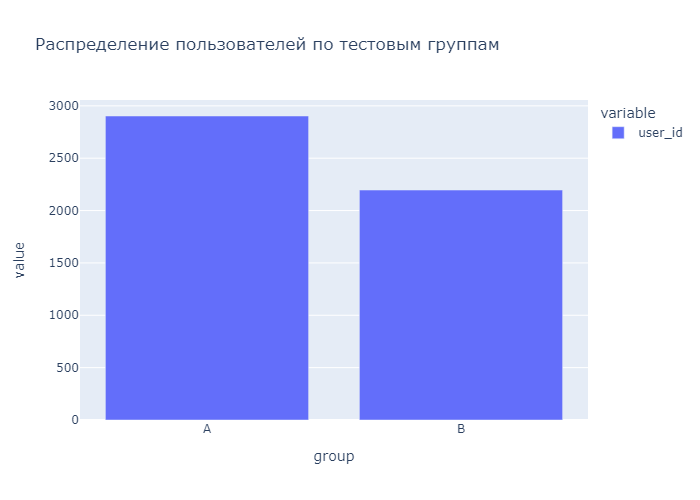

In [22]:
fig_1 = px.bar (data_ab_users_recommender.groupby ('group')['user_id'].count(),
                title = 'Распределение пользователей по тестовым группам')
fig_1.show ('png')

Пользователи распределены неравномерно. Количество пользователей в группе "B" почти на 25% меньше количества пользователей в контрольной группе.

Объединим три датасета в один по идентификатеру `user_id`, убрав лишние столбцы. Корректные временные промежутки и регион уже сохранены в соответствующих датасетах.

In [23]:
data_merge = data_ab_users_recommender.merge (data_new_users, on = 'user_id', how = 'inner')
data_merge = data_merge.merge (data_ab_events, on = 'user_id', how = 'inner')
data_merge = data_merge.drop (['ab_test', 'region'], axis = 1)
data_merge ['life'] = pd.DatetimeIndex (data_merge ['event_dt']).day - pd.DatetimeIndex (data_merge ['first_date']).day
data_merge = data_merge.query ('life <= 14')
data_merge.sample (5)

,user_id,group,first_date,device,event_dt,event_name,details,life
915,13805E998FE5D7B8,A,2020-12-20,PC,2020-12-20 13:53:13,purchase,9.99,0
17234,4E5468B5BBE458DE,A,2020-12-14,PC,2020-12-16 01:59:51,product_page,NaN,2
7915,92EFA54F7198BC87,B,2020-12-08,Android,2020-12-16 10:12:01,product_page,NaN,8
4640,E2F9D9C5F177CBE9,B,2020-12-18,Android,2020-12-18 05:18:01,login,NaN,0
2250,7D8B4A3F6C824DC0,A,2020-12-17,iPhone,2020-12-17 22:03:21,product_page,NaN,0


**Вывод**

A\B тест был проведён во время новогодних праздников параллельно с проведением новогодней маркетинговой кампании и другого теста, частично затрагивающего тех же пользователей. Это повлияло как на размер выборочных групп, так и на их соотношение. После очистки данных количество пользователей, принимающих участие в тестировании, составило 5099 человек - это примерно 12% от количества новых пользователей из региона `EU`.

## Исследовательский анализ данных
### Распределение количества событий на пользователя по группам

Проверим распределение количества событий на одного пользователя среди двух групп.

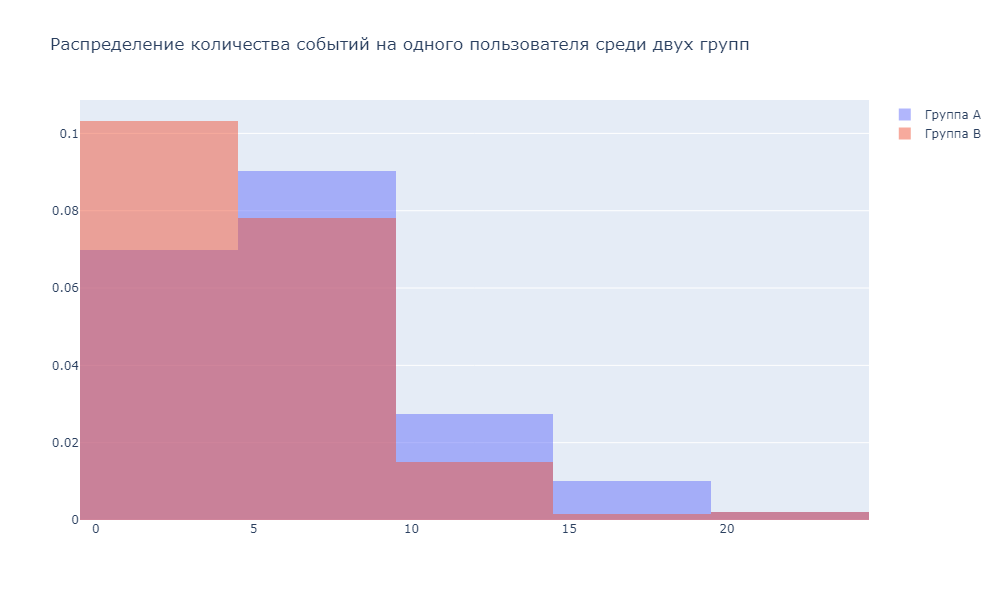

group
A    6.956679
B    5.493130
Name: event_dt, dtype: float64

In [24]:
data_show = data_merge.groupby (['group', 'user_id'])['event_dt'].count().reset_index()

fig = go.Figure()
for i, j in zip ([data_show.query ('group == "A"'), data_show.query ('group == "B"')], ['Группа A', 'Группа B']):

    fig.add_trace (go.Histogram (x = i ['event_dt'],
                                 name = j,
                                 histnorm = 'probability density',
                                 nbinsx = 10))

fig.update_layout (barmode = 'overlay',
                   title_text = 'Распределение количества событий на одного пользователя среди двух групп',
                   height = 600,
                   width = 1000)
fig.update_traces (opacity = 0.5)
fig.show ('png')

display (data_show.groupby ('group')['event_dt'].mean())

**Вывод:** Количество событий на пользователя распределено неравномерно. Пользователи группы `B` совершали чаще до 4 событий, но в среднем, пользователи группы `B` совершали меньше событий.

### Распределение числа событий в выборках по дням

Добавим в датасет столбец с номером дня, когда произошло событие. Построим распределение.

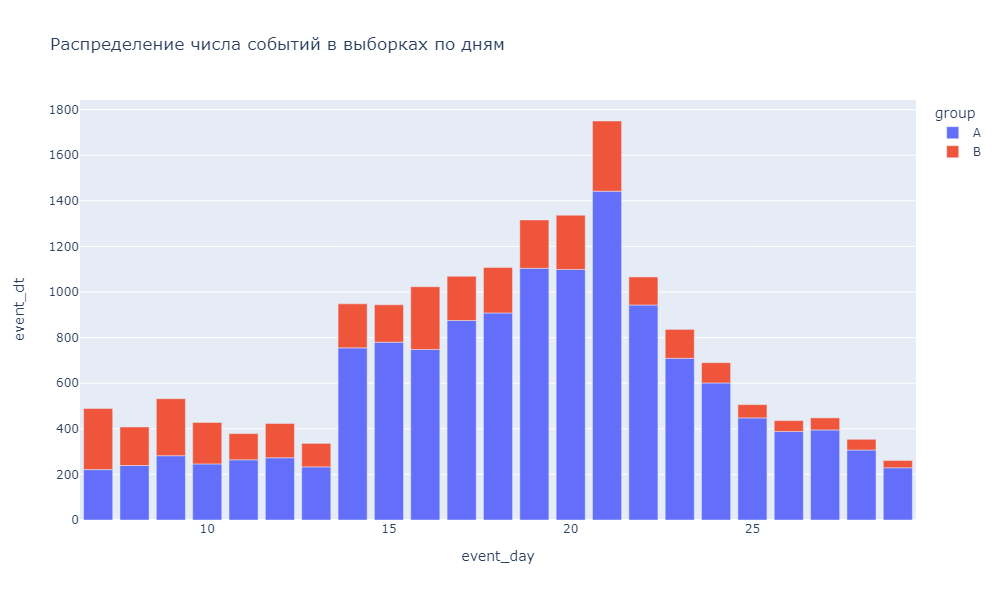

In [25]:
data_merge ['event_day'] = pd.DatetimeIndex (data_merge ['event_dt']).day
fig = px.bar (data_merge.groupby (['group', 'event_day'])['event_dt'].count().reset_index(),
              x = 'event_day',
              y = 'event_dt',
              color = 'group',
              title = 'Распределение числа событий в выборках по дням',
              height = 600,
              width = 1000)
fig.show ('png')

**Вывод:** Активность группы "А" намного больше активности группы "B". Начиная с 14 декабря (спустя неделю после начала A\B теста) активность в группе "A" значительно выросла, а активность группы "B" примерно осталась на том же уровне. Пик активности пришёлся на 21 декабря (1442 события в группе "А" и 308 событий в группе "B". Проверим также распределение пользователей по `first_date`.

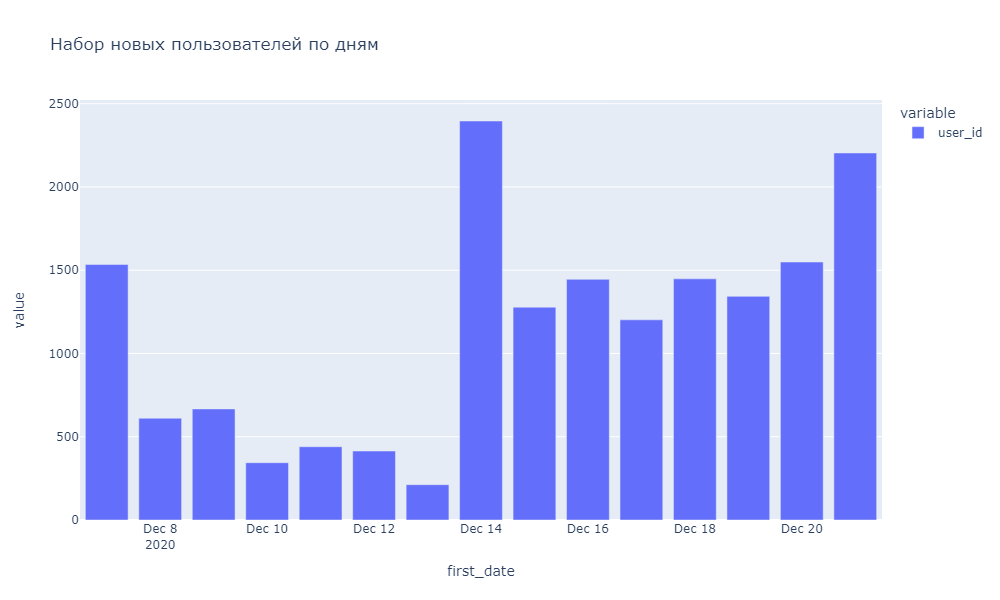

In [26]:
fig = px.bar (data_merge.groupby ('first_date')['user_id'].count(),
              title = 'Набор новых пользователей по дням',
              height = 600,
              width = 1000)
fig.show ('png')

С 14-го числа количество клиентов резко выросло.

###  Изменение конверсии в воронке в выборках на разных этапах

Создадим сводную таблицу для визуализации воронки продаж.

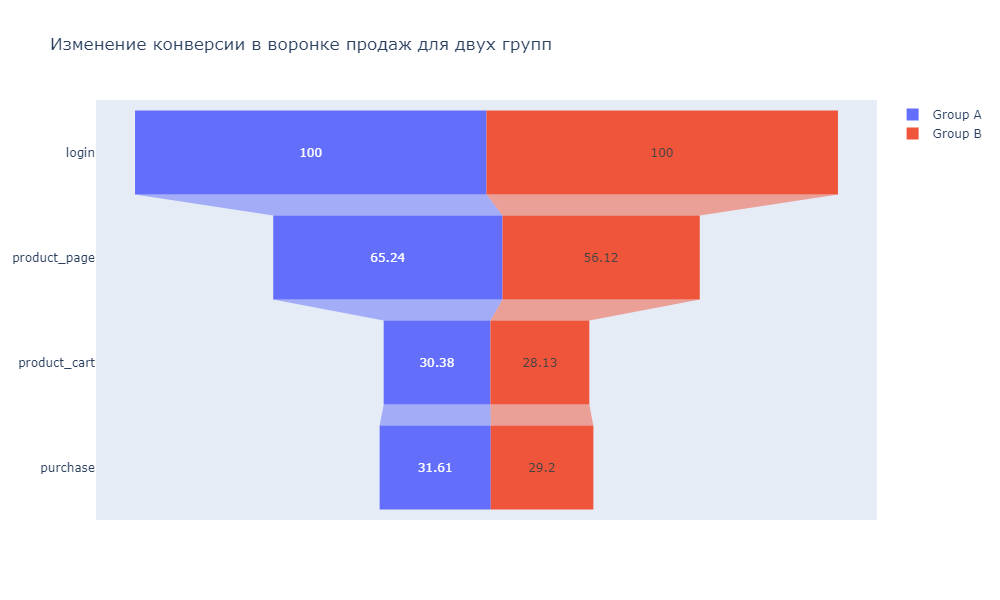

In [27]:
data_merge_pivot = pd.pivot_table (data_merge,
                                   index = 'event_name',
                                   columns = 'group',
                                   values = 'user_id',
                                   aggfunc = 'nunique').reset_index()

data_merge_pivot ['perc_a'] = round (data_merge_pivot ['A'] / data_merge_pivot.loc [0, 'A'] * 100, 2)
data_merge_pivot ['perc_b'] = round (data_merge_pivot ['B'] / data_merge_pivot.loc [0, 'B'] * 100, 2)

# Функиця для ранжирования событий в воронке
def event_rank (event_name):
    if event_name == 'login':
        rank_value = 1
    elif event_name == 'product_page':
        rank_value = 2
    elif event_name == 'product_cart':
        rank_value = 3
    else:
        rank_value = 4
    return rank_value

data_merge_pivot ['rank'] = data_merge_pivot ['event_name'].apply (event_rank)
data_merge_pivot = data_merge_pivot.sort_values (by = 'rank')

fig = go.Figure()

fig.add_trace (go.Funnel (name = 'Group A',
                          x = data_merge_pivot ['perc_a'],
                          y = data_merge_pivot ['event_name']))

fig.add_trace (go.Funnel (name = 'Group B',
                          x = data_merge_pivot ['perc_b'],
                          y = data_merge_pivot ['event_name']))

fig.update_layout (title_text = 'Изменение конверсии в воронке продаж для двух групп',
                   height = 600,
                   width = 1000)

fig.show ('png')

**Вывод:** Воронка показывает неравномерное распределение клиентов между двумя группами. В целом конверсия группы "B" стабильно хуже, чем конверсия группы "A". При этом, судя по воронке, клиенты могут купить товар в обход корзины, т.к. мы имеем большее количество клиентов с покупкой, чем клиентов, зашедших на станицу с корзиной.

## Оценка результатов A/B-тестирования
### Создание расчётных функций для анализа

Ожидаемый эффект A\B теста, согласно ТЗ: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%.

Напишем функцию для расчёта кумулятивных значений.

In [28]:
days_and_groups = data_merge [['event_day', 'group']].drop_duplicates().sort_values (by = 'event_day')

def cumulative (data, column, agg_func, col_name):
    
    result = days_and_groups.apply (lambda x: data [np.logical_and (data ['event_day'] <= x ['event_day'],
                                                                    data ['group'] == x ['group'])] \
                            .agg ({'event_day': 'max',
                                   'group': 'max',
                                   column: agg_func}), axis = 1) \
                            .sort_values (by = ['event_day', 'group']) \
                            .rename ({column: col_name}, axis = 1)
    return result

Напишем функци для расчёта конверсии по кумулятивным значениям.

In [29]:
def conversion (column):
    data_login = data_merge.query ('event_name == "login"')
    data_col = data_merge.query ('event_name == @column')

    data_visitors = cumulative (data_login, 'user_id', 'nunique', 'visitors')
    data_orders = cumulative (data_col, 'user_id', 'nunique', 'orders')

    data_conversion = data_visitors.merge (data_orders, on = ['event_day', 'group'])
    data_conversion ['conversion'] = round (data_conversion ['orders'] / data_conversion ['visitors'], 2)
    
    data_conversion_a = data_conversion.query ('group == "A"')
    data_conversion_b = data_conversion.query ('group == "B"')
    data_conversion_merge = data_conversion_a.merge (data_conversion_b, on = 'event_day', suffixes = ['_a', '_b'])
    data_conversion_merge ['relative_conversion'] = (data_conversion_merge ['conversion_b'] / data_conversion_merge ['conversion_a']) - 1
    
    return data_conversion, data_conversion_merge

Напишем функцию для визуализации линейных графиков в сравнении по двум группам.

In [30]:
def show_line (data_1, data_2, y_value_1, y_value_2, title_value_1, title_value_2):
    
    fig_1 = px.line (data_1,
                     x = 'event_day',
                     y = y_value_1,
                     color = 'group',
                     title = title_value_1,
                     height = 600,
                     width = 1000)

    fig_2 = px.line (data_2,
                     x = 'event_day',
                     y = y_value_2,
                     title = title_value_2,
                     height = 600,
                     width = 1000)
    
    fig_2.add_hline (y = 0, line_dash = 'dot')
     
    fig_1.show ('png')
    fig_2.show ('png')

### Анализ конверсии просмотра товара

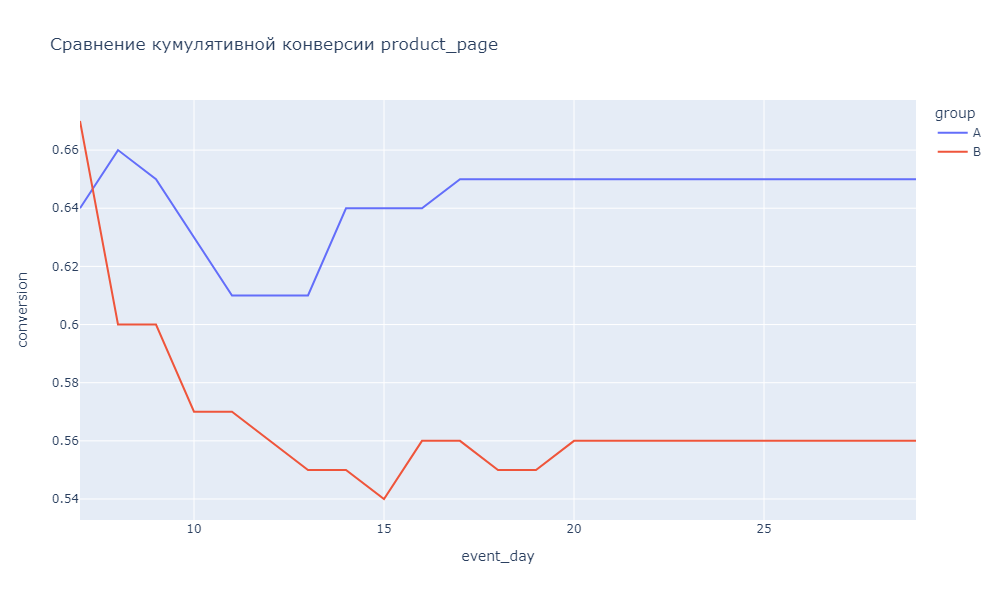

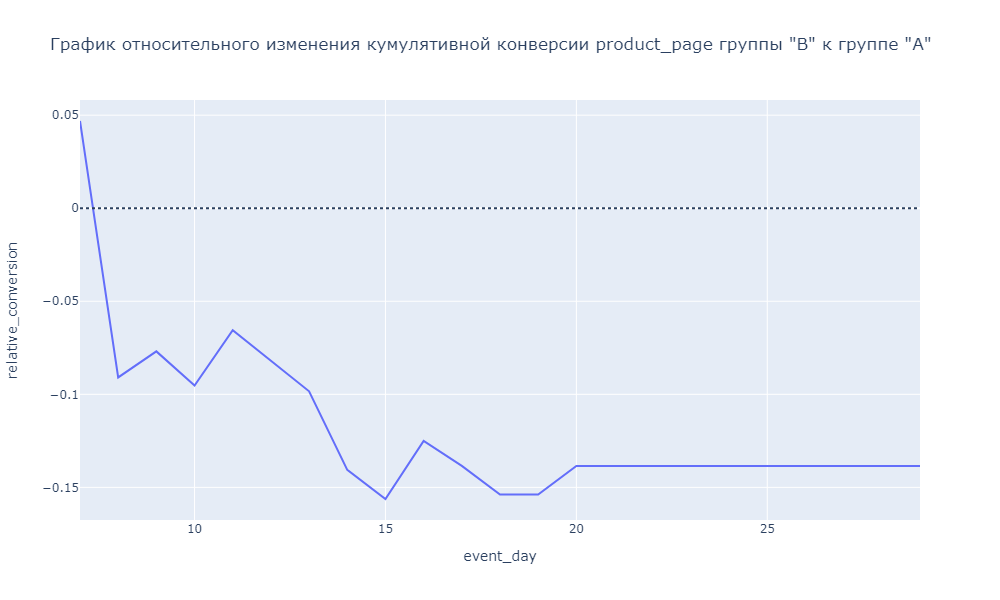

In [31]:
conversion_product_page, conversion_product_page_merge = conversion ('product_page')

show_line (conversion_product_page,
           conversion_product_page_merge,
           'conversion',
           'relative_conversion',
           'Сравнение кумулятивной конверсии product_page',
           'График относительного изменения кумулятивной конверсии product_page группы "B" к группе "A"')

**Вывод:** Конверсия группы "B" с самого первого дня была ниже, чем в группе "A". Динамика в обеих группах выровнялась только после 20-го декабря, разница между группами составила 9%. Ожидания согласно ТЗ не оправдались.

### Анализ конверсии просмотра корзины

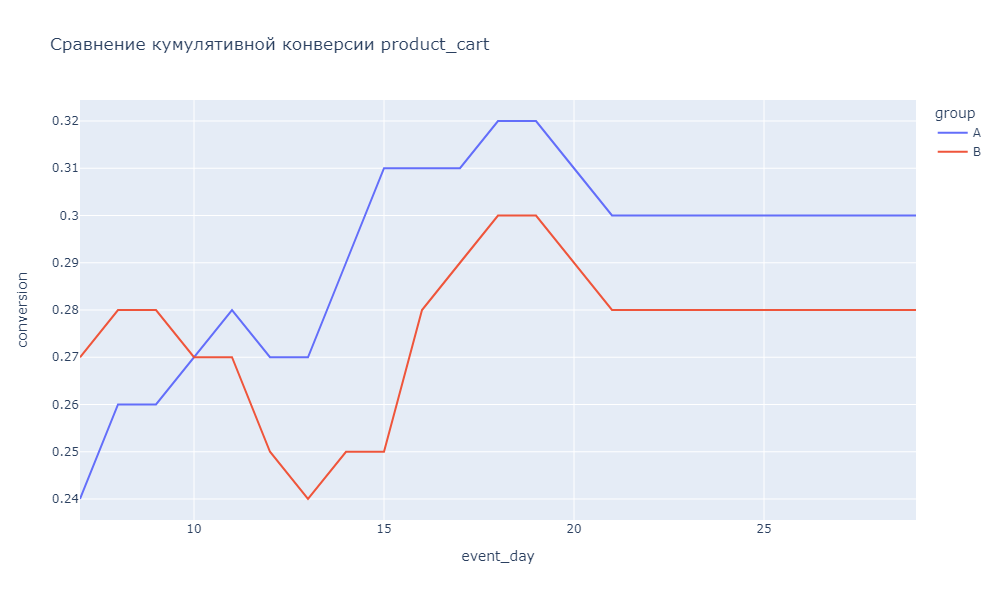

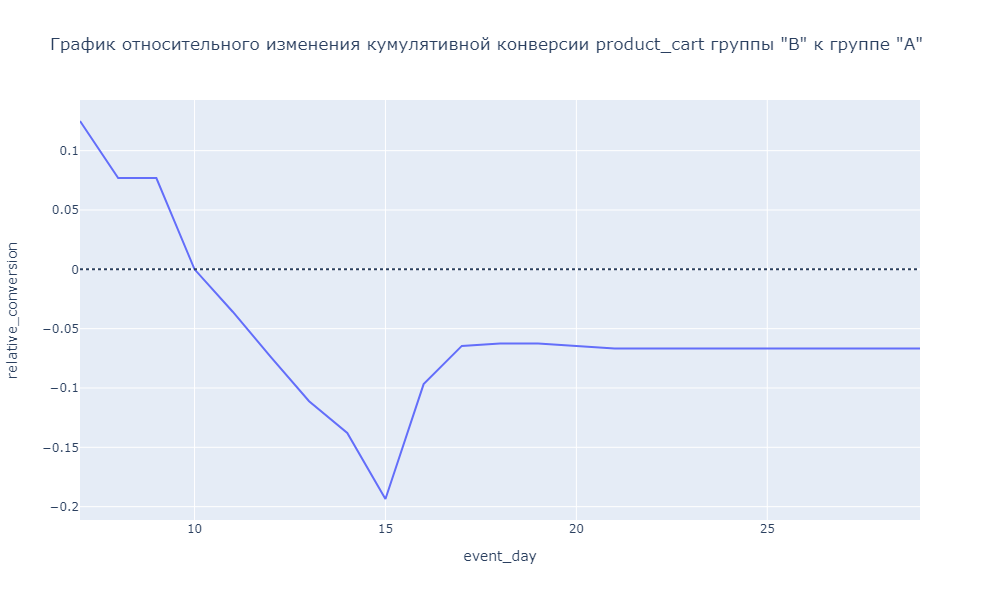

In [32]:
conversion_product_cart, conversion_product_cart_merge = conversion ('product_cart')
show_line (conversion_product_cart,
           conversion_product_cart_merge,
           'conversion',
           'relative_conversion',
           'Сравнение кумулятивной конверсии product_cart',
           'График относительного изменения кумулятивной конверсии product_cart группы "B" к группе "A"')

**Вывод:** Конверсия в группе "B" падала до 13 декабря, после чего начала увеличиваться (до 19 декабря), в то время как конверсия группы "A" активно росла до 19 декабря включительно. Относительные изменения между группами выровнялись после 17 декабря, разница между группами составила 2%. Ожидания согласно ТЗ не оправдались.

### Анализ конверсии покупок

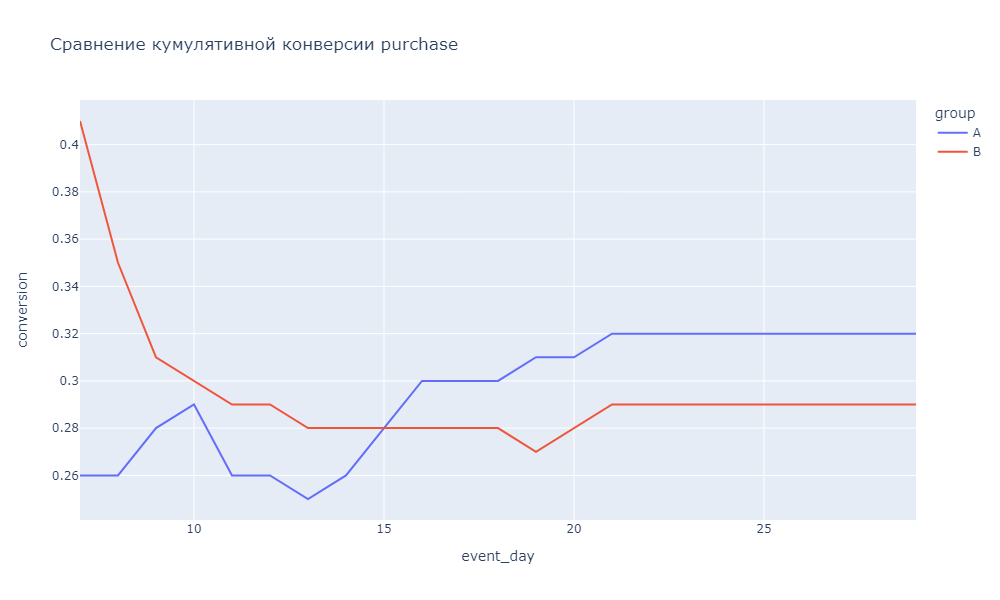

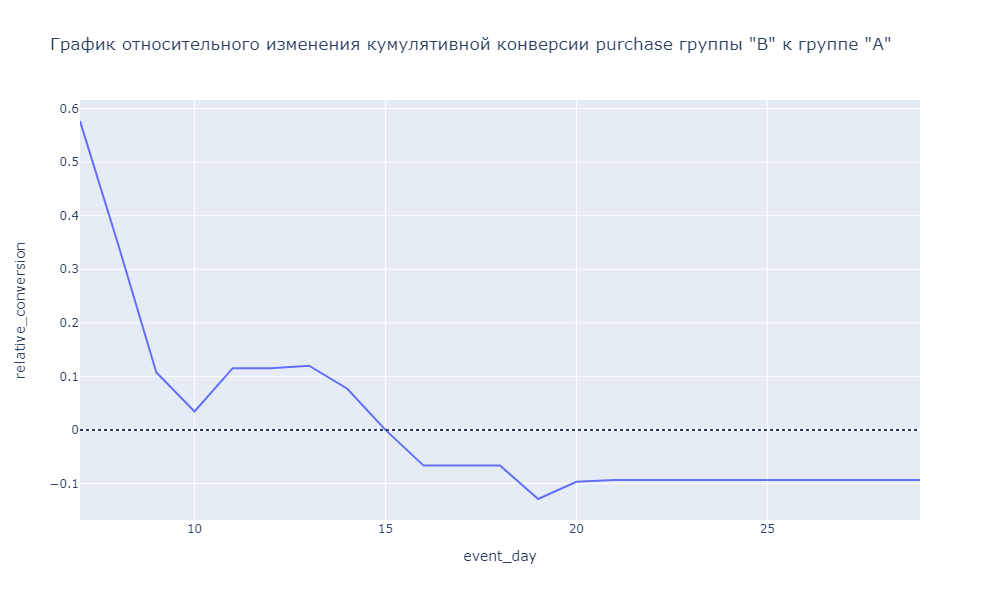

In [33]:
conversion_purchase, conversion_purchase_merge = conversion ('purchase')
show_line (conversion_purchase,
           conversion_purchase_merge,
           'conversion',
           'relative_conversion',
           'Сравнение кумулятивной конверсии purchase',
           'График относительного изменения кумулятивной конверсии purchase группы "B" к группе "A"')

**Вывод:** До 15 декабря конверсия группы "B" была выше, чем у группы "A", однако, после 15 декабря ситуация изменилась, и после выравнивания изменений между группами, разница составила 3%.  Ожидания согласно ТЗ не оправдались.

### Анализ выручки

Для расчёта выручки воспользуемся написанными ранее функциями, заменив способ расчёта относительных значений.

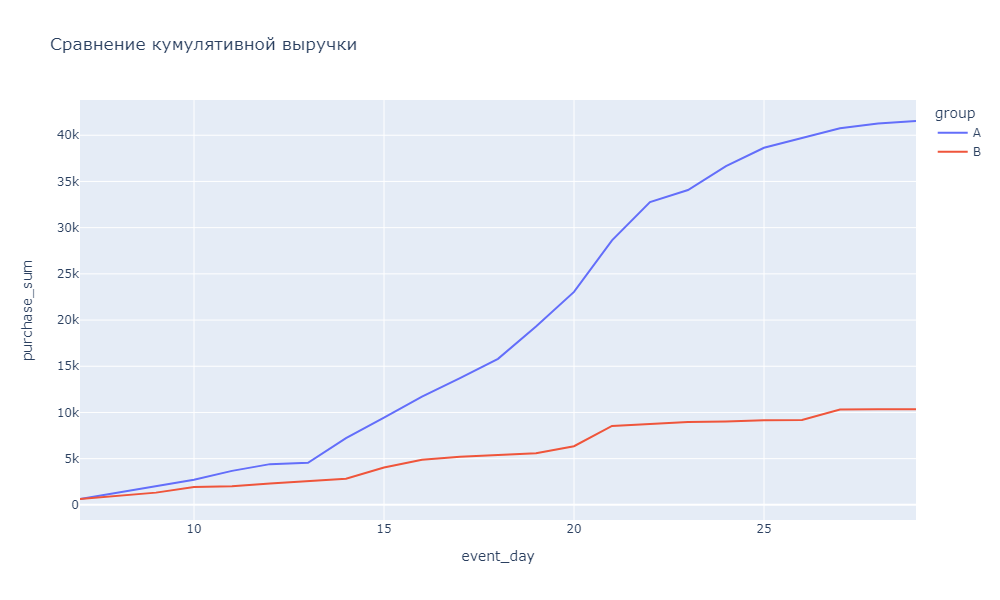

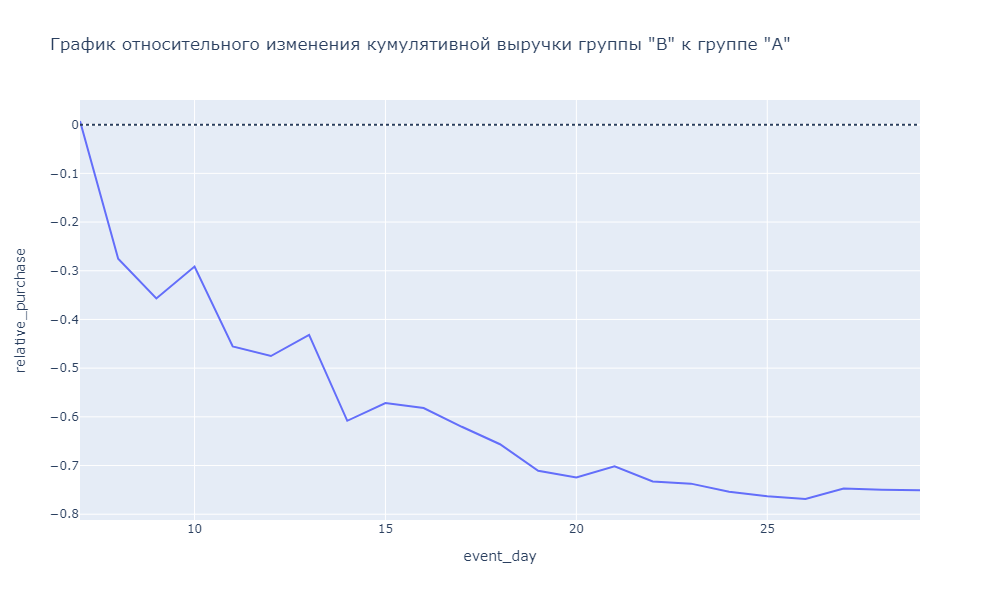

In [34]:
purchase_detail_cumulative = cumulative (data_merge.query ('event_name == "purchase"'),
                                         'details',
                                         'sum',
                                         'purchase_sum')

purchase_detail_cumulative_a = purchase_detail_cumulative.query ('group == "A"')
purchase_detail_cumulative_b = purchase_detail_cumulative.query ('group == "B"')

purchase_detail_cumulative_merge = purchase_detail_cumulative_a.merge (purchase_detail_cumulative_b,
                                                                       on = 'event_day',
                                                                       suffixes = ['_a', '_b'])

purchase_detail_cumulative_merge ['relative_purchase'] = (purchase_detail_cumulative_merge ['purchase_sum_b'] / purchase_detail_cumulative_merge ['purchase_sum_a']) - 1

show_line (purchase_detail_cumulative,
           purchase_detail_cumulative_merge,
           'purchase_sum',
           'relative_purchase',
           'Сравнение кумулятивной выручки',
           'График относительного изменения кумулятивной выручки группы "B" к группе "A"')

**Вывод:** По итогу A/B теста выручка группы "B" в 4 раза меньше группы "A". Однако, причиной этому является неравномерное соотношение количества участников в группе. Для более наглядного понимания соотношения динамики получения ежедневной выручки посмотрим линейный график по процентному изменению выручки в каждой группе за каждый день, и сравним их между собой.

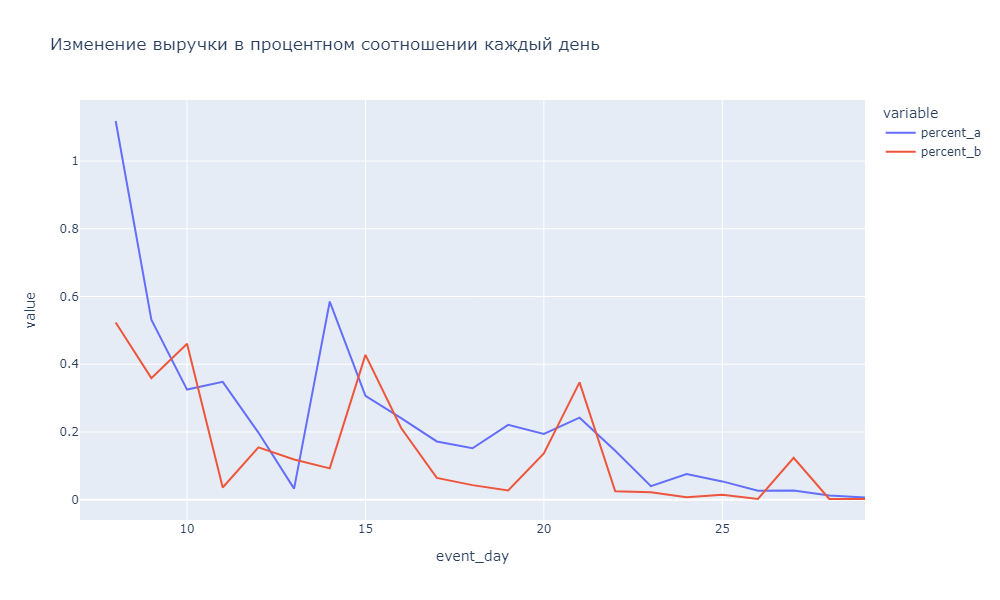

In [35]:
purchase_detail_cumulative_merge ['percent_a'] = purchase_detail_cumulative_merge ['purchase_sum_a'].pct_change()
purchase_detail_cumulative_merge ['percent_b'] = purchase_detail_cumulative_merge ['purchase_sum_b'].pct_change()

fig = px.line (purchase_detail_cumulative_merge,
               x = 'event_day',
               y = ['percent_a', 'percent_b'],
               title = 'Изменение выручки в процентном соотношении каждый день',
               height = 600,
               width = 1000)
fig.show ('png')

**Вывод:** Несмотря на большую разницу в выручке между группами, динамика процентного соотношения внутри групп примерно одинаковая. Также следует отметить, что чем дольше шёл A/B тест, тем меньше становился прирост ежедневной выручки.

### Проверка статистической разницы долей z-критерием

Оценим статистическую значимость разницы долей, для пользователей, совершивших значимые действия `product_page`, `product_cart` и `purchase`. Напишем функцию для проверки гипотезы о равенстве долей.

In [36]:
def z_test (tag):
    
    data_pivot = pd.pivot_table (data_merge.query ('event_name == @tag or event_name == "login"'),
                                 index = 'event_name',
                                 columns = 'group',
                                 values = 'user_id',
                                 aggfunc = 'nunique').sort_values (by = 'A', ascending = False).reset_index()
                   
    alpha = .05
    
    successes = np.array ([data_pivot.loc [1, 'A'], data_pivot.loc [1, 'B']])
    trials = np.array ([data_pivot.loc [0, 'A'], data_pivot.loc [0, 'B']])
    
    p1 = successes [0] / trials [0]
    p2 = successes [1] / trials [1]
    
    print(successes [0], successes [1], trials [0], trials [1])
    
    p_combined = (successes [0] + successes [1]) / (trials [0] + trials [1])
    
    difference = p1 - p2
    
    z_value = difference / mth.sqrt (p_combined * (1 - p_combined) * (1 / trials [0] + 1 / trials [1]))
    
    distr = st.norm (0, 1)
    
    p_value = (1 - distr.cdf (abs (z_value))) * 2
    
    print ('p-значение: ', p_value)

    if p_value < alpha:
        print ('Отвергаем нулевую гипотезу')
    else:
        print ('Не получилось отвергнуть нулевую гипотезу') 

Сформулируем нулевую и альтернативную гипотезы:

**H0:** Среднее количество пользователей совершивших значимое событие в группах A и B одинаковое

**H1:** Среднее количество пользователей совершивших значимое событие в группах A и B различается

In [37]:
for i in ['product_page', 'product_cart', 'purchase']:
    print (f'Результат проверки статистической гипотезы о равенстве долей по признаку {i}')
    z_test (i)
    print()

Результат проверки статистической гипотезы о равенстве долей по признаку product_page
1265 367 1939 654
p-значение:  2.9463911899618722e-05
Отвергаем нулевую гипотезу

Результат проверки статистической гипотезы о равенстве долей по признаку product_cart
589 184 1939 654
p-значение:  0.2784249853300258
Не получилось отвергнуть нулевую гипотезу

Результат проверки статистической гипотезы о равенстве долей по признаку purchase
613 191 1939 654
p-значение:  0.24933015751802245
Не получилось отвергнуть нулевую гипотезу



**Вывод:** Имеется статистически значимое различие между долями конверсии пользователей по признаку `product_page`. Признаки `product_cart` и `purchase` по конверсии между группами различаются не критично.

## Общие выводы и рекомендации

**Оценка проведения A/B теста:**

* Дата остановки теста, указанная в ТЗ, оказалась на 5 дней больше, чем дата последней записи в датасете о событиях пользователей.
* В период проведения A\B теста проводились две маркетинговые кампании, одна из которых (Christmas&New Year Promo) проходила среди пользователей из региона EU, имеющими отношение к нашему A\B тесту. Это могло повлиять на активность пользователей при приведении теста.
* Доля пользователей, пересекающихся с пользователями из группы "B" в конкурирующем тесте (interface_eu_test) составляет 11.68 %.
* Фактическое количество участников теста превышает ожидаемые показатели.
* Пользователи распределены неравномерно между двумя группами. Количество пользователей в группе "B" почти на 25% меньше количества пользователей в контрольной группе.

**Анализ результатов A/B теста:**

* Активность группы "А" намного больше активности группы "B". Начиная с 14 декабря (спустя неделю после начала A\B теста) активность в группе "A" значительно выросла, а активность группы "B" примерно осталась на том же уровне. Пик активности пришёлся на 21 декабря (1442 события в группе "А" и 308 событий в группе "B".
* В целом конверсия группы "B" стабильно хуже, чем конверсия группы "A". При этом, судя по воронке продаж, клиенты могут купить товар в обход корзины (покупка в один клик).
* Ожидаемый эффект A\B теста не подтвердился. По всем трём ключевым показателям (product_page, product_cart, purchase) конверсия пользователей в группе B стабильно хуже конверсии контрольной группы.
* Чем дольше шёл A/B тест, тем меньше становился прирост ежедневной выручки.
* Имеется статистически значимое различие между долями конверсии пользователей по признаку product_page

**Рекомендации:**

Необходимо перезапустить A\B тест, учитывая конркурирующие тесты, праздничные дни и маркетинговую активность. Также для корректных результатов теста необходимо добиться равномерного распределения пользователей в обеих группах.